# 프로젝트: 한국어 데이터로 챗봇 만들기
---
트랜스포머 모델을 이용하여 챗봇 만들기

In [1]:
# 필요한 라이브러리 불러오기

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

## Step 4. 모델 구성하기
---
위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### 포지셔널 인코딩
---
- 트랜스포더는 문장 벡터를 한번에 입력하기 때문에 현재의 단어가 무엇인지 표시해주는 포지셔널 행렬이 필요하다
- 임베딩 벡터에 포지셔널 인코딩 행렬의 값을 더한다

In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

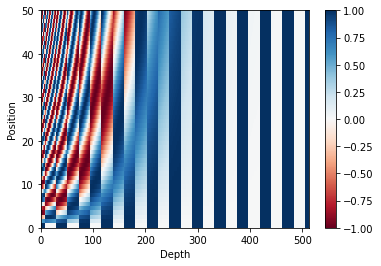

In [3]:
# 포지셔널 인코딩 레이어 인스턴스 생성
# 행의 크기가 50, 열의 크기가 512
pos_encoding_layer = PositionalEncoding(50, 512)

# 더미 입력 생성 (배치 크기: 1, 시퀀스 길이: 50, 임베딩 차원: 512)
dummy_input = tf.zeros((1, 50, 512))

# 레이어 호출하여 포지셔널 인코딩을 더함
output_with_pos_encoding = pos_encoding_layer(dummy_input)

# 포지셔널 인코딩만 추출 (첫 번째 배치)
sample_pos_encoding = output_with_pos_encoding - dummy_input

# 시각화
plt.pcolormesh(sample_pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 스케일드 닷 프로덕트 어텐션
---
단어들간의 유사도를 구하는 함수인 어텐션을 구현

In [4]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True) # 두번째 입력행렬을 전치

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

### 멀티헤드 어텐션
---
- 임베딩 벡터의 차원을 쪼개에 어텐션을 수행한다
- `num_head` : 멀티헤드 어텐션의 머리의 개수
- input : [batch_size, seq_len, d_model] > [batch_size, seq_len, num_heads, depth]
- tf.transpose 연산 후 [batch_size, num_heads, seq_len, depth] 순으로 바뀐다

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

# 입력을 여러 헤드로 나눔
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth)) # 나눈 후의 shape
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) # 병렬연산 가능하게하기위해 축 순서 바꿈

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

### 마스킹
---
특정 값을 가려서 실제 연산에 방해가 되지 않도록 하는 기법

#### 1) 패딩 마스킹
- 패딩 : 일정 길이보다 짧은 문장에 0을 채움으로써 서로 다른 문장의 길이를 맞춰준다
- 숫자 0인 위치를 체크해 연산에서 제외시킴

In [6]:
# 이 함수는 숫자가 0인 부분을 T, 아닌부분을 F로체크한 벡터를 리턴합니다.
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# 테스트
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


#### 2) 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
- 현재위치 이후에 오는 단어들은 연산에서 제외시킴
- `tf.linalg.band_part`(tf.ones((seq_len, seq_len)), -1, 0) :
파라미터로 받은 행렬 크기만큼의 대각선 아래 값 제외하고 모두 1 채워넣은 행렬 반환

In [8]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [9]:
# 테스트
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [10]:
# 행렬에 패딩값 있을 시 테스트
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### 인코더
---
- 하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어짐
- 셀프 어텐션과 피드 포워드 신경망
- 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어짐

#### 인코더 레이어

In [11]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 인코더 층 쌓기

In [12]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32)) # 스케일링

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask]) # encoder_layer의 인스턴스 생성 후 호출

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 디코더
---

#### 디코더 층 만들기
- 첫 번째는 셀프 어텐션, 두 번째는 인코더-디코더 어텐션, 세 번째는 피드 포워드 신경망
- 인코더-디코더 어텐션 : Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있음
- 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정
- 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 `스케일드 닷 프로덕트 어텐션`을 `멀티 헤드 어텐션`으로 병렬적으로 수행

In [13]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

#### 디코더 층을 쌓아 디코더 만들기
- 디코더의 층은 임베딩 층(Embedding layer) 과 포지셔널 인코딩(Positional Encoding) 을 연결
- 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성
- 인코더와 마찬가지로 num_layers 개수의 디코더 층을 쌓음

In [14]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)


  for i in range(num_layers): # num_layer만큼 디코더층 생성
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## Step 1. 데이터 수집하기
---

### 데이터 가져오기

In [15]:
# 데이터셋 경로 저장
dataset_dir = '~/aiffel/transformer_chatbot/data/ChatbotData .csv'
dataset_dir

'~/aiffel/transformer_chatbot/data/ChatbotData .csv'

In [16]:
# 데이터프레임으로 읽어들이기
df = pd.read_csv(dataset_dir)

In [17]:
# 리스트로 변환
questions = df['Q'].tolist()
answers = df['A'].tolist()

In [18]:
print(len(questions), len(answers))

11823 11823


## Step 2. 데이터 전처리하기
---
- 문장에서 단어와 구두점 사이에 공백을 추가한다.
- 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.

In [19]:
# 전처리 함수
def preprocess_sentence(sentence):
  # 입력받은 sentence를 문장 양쪽 공백을 제거
  sentence = sentence.strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (한글, 숫자 ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^가-힣0-9?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [20]:
questions_prcd = preprocess_sentence(questions[0])
answers_prcd = preprocess_sentence(answers[0])

print('전처리전 :', questions[0], answers[0])
print('전처리후 :', questions_prcd, answers_prcd)

전처리전 : 12시 땡! 하루가 또 가네요.
전처리후 : 12시 땡 ! 하루가 또 가네요 .


In [21]:
# Q, A 리스트 모든 원소에 대해 전처리 함수 적용

# 리스트 개수만큼 리스트 원소헤 함수 적용해준후 다시 새 리스트 붙이기
def preprocess_sentence_list(Q, A):
    questions_prcd = []
    answers_prcd = []
    
    for question, answer in zip(Q, A):        
        q = preprocess_sentence(question)
        a = preprocess_sentence(answer)
        
        questions_prcd.append(q)
        answers_prcd.append(a)
        
    return questions_prcd, answers_prcd

In [22]:
questions_prcd, answers_prcd = preprocess_sentence_list(questions, answers)

In [67]:
# 전처리 결과
# questions_prcd, answers_prcd

## Step 3. SubwordTextEncoder 사용하기
---
한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 
하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

In [24]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions_prcd + answers_prcd, target_vocab_size=2**13)

In [25]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [26]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8156]
END_TOKEN의 번호 : [8157]


In [27]:
# 두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 합니다.
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8158


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
- tensorflow_datasets의 `SubwordTextEncoder`를 사용해서 tokenizer를 정의하고 Vocabulary를 생성 후
- `tokenizer.encode()`로 각 단어를 정수로 변환할 수 있음
- `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

In [28]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.

print('정수 인코딩 전 질문 샘플: {}'.format(questions_prcd[21]))
print('정수 인코딩 전 답변 샘플: {}'.format(answers_prcd[21]))

# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions_prcd[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers_prcd[21])))

정수 인코딩 전 질문 샘플: 가스비 장난 아님
정수 인코딩 전 답변 샘플: 다음 달에는 더 절약해봐요 .
정수 인코딩 후의 21번째 질문 샘플: [5756, 612, 2484, 4158]
정수 인코딩 후의 21번째 답변 샘플: [2354, 7499, 7, 6262, 97, 1]


In [29]:
print('질문의 최대길이 :{}'.format(max(len(q) for q in questions_prcd)))
print('대답의 최대길이 :{}'.format(max(len(q) for q in answers_prcd)))

질문의 최대길이 :57
대답의 최대길이 :78


In [30]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [31]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [32]:
# 정수 인코딩 과정을 수행하면서 샘플의 길이가 40을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다.
# 단어장의 크기와 샘플의 개수를 확인해 보겠습니다.

questions_filterd, answers_filterd = tokenize_and_filter(questions_prcd, answers_prcd)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions_filterd)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers_filterd)))

단어장의 크기 : 8158
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### 3. 교사 강요(Teacher Forcing) 사용하기
- 질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다.
- 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용합니다.

In [40]:
BATCH_SIZE = 32
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_filterd,
        'dec_inputs': answers_filterd[:, :-1]
    },
    {
        'outputs': answers_filterd[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### 모델 정의 및 학습하기
---
이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.

In [41]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

#### 1. 모델 생성

In [42]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3142656     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 2. 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [43]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 3. 커스텀 된 학습률(Learning rate)

In [44]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 4. 모델 컴파일
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [45]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

#### 5. 훈련하기

In [47]:
EPOCHS = 20
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

# loss: 0.0041 - accuracy: 0.1740

Epoch 1/20
370/370 [==============================] - 33s 88ms/step - loss: 0.6870 - accuracy: 0.0743
Epoch 2/20
370/370 [==============================] - 33s 88ms/step - loss: 0.5848 - accuracy: 0.0852
Epoch 3/20
370/370 [==============================] - 33s 88ms/step - loss: 0.4825 - accuracy: 0.0966
Epoch 4/20
370/370 [==============================] - 33s 88ms/step - loss: 0.3857 - accuracy: 0.1085
Epoch 5/20
370/370 [==============================] - 29s 79ms/step - loss: 0.3029 - accuracy: 0.1190
Epoch 6/20
370/370 [==============================] - 24s 64ms/step - loss: 0.2395 - accuracy: 0.1278
Epoch 7/20
370/370 [==============================] - 14s 38ms/step - loss: 0.1903 - accuracy: 0.1356
Epoch 8/20
370/370 [==============================] - 14s 38ms/step - loss: 0.1440 - accuracy: 0.1438
Epoch 9/20
370/370 [==============================] - 14s 38ms/step - loss: 0.1084 - accuracy: 0.1510
Epoch 10/20
370/370 [==============================] - 14s 38ms/step - loss: 0.084

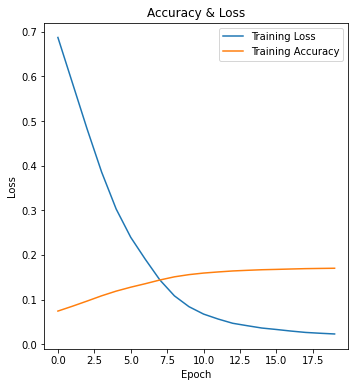

In [65]:
import matplotlib.pyplot as plt

# 훈련 과정의 손실값과 정확도를 history 객체로부터 가져옵니다.
loss = history.history['loss']
accuracy = history.history['accuracy']

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(accuracy, label='Training Accuracy')
plt.title('Accuracy & Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Step 5. 모델 평가하기
---
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [48]:
# 위의 과정을 모두 담은 decoder_inference() 함수를 만듭니다.

def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :] # batch_size, sequence_length, vocab_size

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

In [49]:
# 임의의 입력 문장에 대해서 decoder_inference() 함수를 호출하여
# 챗봇의 대답을 얻는 sentence_generation() 함수를 만듭니다.

def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [50]:
sentence_generation('갈까 말까?')

입력 : 갈까 말까?
출력 : 가세요 .


'가세요 .'

In [51]:
sentence_generation('기름값 올랐어.')

입력 : 기름값 올랐어.
출력 : 대중교통을 이용해주세요 .


'대중교통을 이용해주세요 .'

In [66]:
sentence_generation('가을 타나 봐.')

입력 : 가을 타나 봐.
출력 : 혼자는 외로운 계절이죠 .


'혼자는 외로운 계절이죠 .'

## 회고
---
#### KEEP
말로만 듣던 transformer모델... 이름에 걸맞게 RNN 모델들을 모두 집약해 놓은 느낌이었다
단어와 단어간의 유사도를 단어 벡터로부터 구하는 어텐션의 개념이 흥미로웠다
#### PROBLEM
이전에 배운 RNN 개념들이 약한것이 느껴졌다
#### TRY
이전 노드들을 복습해야겠다